# Определение перспективного тарифа для телеком компании

### 1. Откройте файл с данными и изучите общую информацию. 

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy import stats as st

calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv')
messages = pd.read_csv('/datasets/messages.csv')
users= pd.read_csv('/datasets/users.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')


print(calls.head(5))
calls.info()
print()

print(internet.head(5))
internet.info()
print()

print(messages.head(5))
messages.info()
print()

print(users.head(5))
users.info()
print()

print(tariffs.head(5))
tariffs.info()

       id   call_date  duration  user_id
0  1000_0  2018-07-25      0.00     1000
1  1000_1  2018-08-17      0.00     1000
2  1000_2  2018-06-11      2.85     1000
3  1000_3  2018-09-21     13.80     1000
4  1000_4  2018-12-15      5.18     1000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB

       id  mb_used session_date  user_id
0  1000_0   112.95   2018-11-25     1000
1  1000_1  1052.81   2018-09-07     1000
2  1000_2  1197.26   2018-06-25     1000
3  1000_3   550.27   2018-08-22     1000
4  1000_4   302.56   2018-09-24     1000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null object
mb_used         149396 non-null float64
se

Для анализа нам представлены 5 датасетов. Первый Calls - содержит информацию об индентефикаторе пользователе, каждом его звонке (дата и продолжительность), совершенном за 2018 год. В таблице "выбиваются" звонки продолжительностью 0.00 минут, что в дальнейшем необходимо скорректировать. Пропусков нет, тип данных неверный только в столбце call_date - должен быть datetime. В датасете internet содержится информация так же идентификатор пользователя, количество сессий выхода в интернет, а так же объем потраченного трафика. Некорректный тип данных опять же у столбца session_date, нужно изменить на datetime., пропусков в датасете нет. Третяя таблица содержит информацию о количестве отправленных клиентом оператора смс-сообщений и дате отправки. Некорректный тип данных опять же у столбца, содержащего информацию о дате отправки (message_date). Датасет users содержит информацию о пятисот пользователях: имя, фамилия, возраст, дата подключения и прекращения, город проживания и название тарифного плана. Пропуски имеются только в столбце churn_date (дата прекращения пользованием), что говорит о том, что клиент не прекратил использовать данного оператора связи. Тип данных неверно указан в столбцах churn_date и reg_date, должен быть datetime. Последний датасет содержит информацию о двух существующих тарифах. Пропусков и неверного типа данных не обнаружено. Следует создать единую сводную таблицу из этих датасетов для дальнейшего анализа.

### 2. Подготовьте данные. 

Приведем даты во всех датасетах к единому виду, а в столбце churn_date датасета users заменим пропущенные значения на 31 декабря 2018 года (последнее число года), так как клиент на этот момент еще пользовался услугами оператора.

In [3]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format = '%Y-%m-%d')
internet['session_date'] = pd.to_datetime(internet['session_date'], format = '%Y-%m-%d')
messages['message_date'] = pd.to_datetime(messages['message_date'], format = '%Y-%m-%d')
users['reg_date'] = pd.to_datetime(users['reg_date'], format = '%Y-%m-%d')

users['churn_date'] = users['churn_date'].fillna('2018-12-31')
users['churn_date'] = pd.to_datetime(users['churn_date'], format = '%Y-%m-%d')

В таблице calls, как уже обозначали, в столбце длительности совершенного звонка (duration) достаточно большое количество значений равных 0.00 (39 613 или 19.6% от общего числа данных), то есть это либо недозвон, либо слишком короткий звонок. Зачастую, мобильные операторы при поминутной тарификации разговоры продолжительностью до трех секунд не учитывают, соответственно, эти значения оставим равным нулю, они не повлияют на общие выводы анализа.

In [4]:
calls_0 = calls['duration'].value_counts()
print(calls_0)

0.00     39613
4.49       142
5.50       142
6.15       141
6.38       141
         ...  
27.02        1
26.19        1
25.34        1
27.13        1
24.28        1
Name: duration, Length: 2871, dtype: int64


В датасеты calls, internet и messages добавим столбцы с данными о месяце, в котором было совершено действие (звонок, интренет-сессия или отправка сообщения):

In [5]:
calls['month_calls'] = calls['call_date'].dt.month
internet['month_internet'] = internet['session_date'].dt.month
messages['month_messages'] = messages['message_date'].dt.month

Для дальнейшего анализа следует округлить длительность звонков до целых минут в большую сторону. На наш взгляд это стоит сделать на данном этапе, а не после того, как найдем общее количество израсходованных минут по каждому месяцу, в связи с тем, что каждая минута и сразу списывается с баланса, даже, если она неполная. В отличие от интернета - округлим до гигабайтов после того, как сложим все имеющиеся ежедневные расходы трафика.

In [6]:
calls['duration'] = np.ceil(calls['duration'], out = None).astype('int')

Для дальшейшего анализа и соединения данных разных датасетов исключим из фрейма users не представляющие интерес для текущего анализа данные - возраст клиента, дата регистрации договора обслуживания, имя и фамилию, а так же дату окончания использования.

In [7]:
users = users.drop(['age', 'churn_date', 'first_name', 'last_name', 'reg_date'], axis=1)
users

,user_id,city,tariff
0,1000,Краснодар,ultra
1,1001,Москва,smart
2,1002,Стерлитамак,smart
3,1003,Москва,ultra
4,1004,Новокузнецк,ultra
...,...,...,...
495,1495,Иркутск,ultra
496,1496,Вологда,smart
497,1497,Челябинск,smart
498,1498,Владикавказ,smart


### 3. Посчитаем для каждого пользователя:

- количество сделанных звонков и израсходованных минут разговора по месяцам;

In [8]:
calls_pivot = (calls[['user_id', 'month_calls', 'duration']]
              .pivot_table(index=['user_id', 'month_calls'], values = 'duration', aggfunc = ['count','sum']))
calls_pivot.columns = ['calls_count', 'total_minutes']
calls_pivot

calls_count  total_minutes
user_id month_calls                            
1000    5                     22            159
        6                     43            172
        7                     47            340
        8                     52            408
        9                     58            466
...                          ...            ...
1498    10                    41            247
1499    9                      9             70
        10                    68            449
        11                    74            612
        12                    69            492

[3174 rows x 2 columns]

- количество отправленных сообщений по месяцам;

In [9]:
messages_pivot = (messages[['user_id', 'month_messages','id']]
              .pivot_table(index=['user_id', 'month_messages'], values = 'id', aggfunc = ['count']))
messages_pivot.columns = ['total_messages']
messages_pivot

total_messages
user_id month_messages                
1000    5                           22
        6                           60
        7                           75
        8                           81
        9                           57
...                                ...
1498    10                          42
1499    9                           11
        10                          48
        11                          59
        12                          66

[2717 rows x 1 columns]

- объем израсходованного интернет-трафика по месяцам;

In [10]:
internet_pivot = (internet[['user_id', 'month_internet','mb_used']]
              .pivot_table(index=['user_id', 'month_internet'], values = 'mb_used', aggfunc = ['sum']))
internet_pivot.columns = ['total_internet_mb']
internet_pivot['total_internet_gb'] = np.ceil(internet_pivot['total_internet_mb']/1024, out = None).astype('int')
internet_pivot

total_internet_mb  total_internet_gb
user_id month_internet                                      
1000    5                         2253.49                  3
        6                        23233.77                 23
        7                        14003.64                 14
        8                        14055.93                 14
        9                        14568.91                 15
...                                   ...                ...
1498    10                       20579.36                 21
1499    9                         1845.75                  2
        10                       17788.51                 18
        11                       17963.31                 18
        12                       13055.58                 13

[3203 rows x 2 columns]

Для дальнейшего анализа произведем слияние имеющихся датасетов, чтобы иметь полное представление об использовании трафика клиентом, для того, чтобы понять, какие расходы делает клиент, и выяснить, какой тариф выгоднее для оператора. Соеденим данные по каждому месяцу, и представим в таблице data.

In [11]:
data = pd.concat([calls_pivot, internet_pivot], axis=1, join='outer')
data = pd.concat([data, messages_pivot], axis=1, join='outer')

data.reset_index(inplace=True)
data.rename(columns={'level_0': 'user_id', 'level_1': 'month'}, inplace=True)
data = data.merge(users)
data.rename(columns={'tariff': 'tariff_name'}, inplace=True)
data = data.merge(tariffs).sort_values('user_id', ascending = True).fillna(0)
data.reset_index(inplace=True)
data = data.drop(['index'], axis=1)
data = data.astype({"calls_count":'int64',
                    "total_minutes":'int64',
                    "total_internet_gb":'int64',
                    "total_messages":'int64'})
data.head(20)

,user_id,month,calls_count,total_minutes,total_internet_mb,total_internet_gb,total_messages,city,tariff_name,messages_included,mg_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,5,22,159,2253.49,3,22,Краснодар,ultra,1000,30720,3000,1950,150,1,1
1,1000,6,43,172,23233.77,23,60,Краснодар,ultra,1000,30720,3000,1950,150,1,1
2,1000,7,47,340,14003.64,14,75,Краснодар,ultra,1000,30720,3000,1950,150,1,1
3,1000,8,52,408,14055.93,14,81,Краснодар,ultra,1000,30720,3000,1950,150,1,1
4,1000,9,58,466,14568.91,15,57,Краснодар,ultra,1000,30720,3000,1950,150,1,1
5,1000,10,57,350,14702.49,15,73,Краснодар,ultra,1000,30720,3000,1950,150,1,1
6,1000,11,43,338,14756.47,15,58,Краснодар,ultra,1000,30720,3000,1950,150,1,1
7,1000,12,46,333,9817.61,10,70,Краснодар,ultra,1000,30720,3000,1950,150,1,1
8,1001,12,63,414,14036.66,14,0,Москва,smart,50,15360,500,550,200,3,3
9,1001,11,59,430,18429.34,18,0,Москва,smart,50,15360,500,550,200,3,3


- помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану).

Для того, чтобы получить сумму ежемесячных трат клиента, посчитаем те рассходы, которые выходят за рамки предложенного тарифного пакета за абонентскую плату, для этого создадим соответствующие столбцы с разницей по минутам, трафику интернета и отправленных смс-сообщений. Далее в столбце m_revenue отразим совокупные траты на оператора - абонентскую плату вместе с стоимостью превышающих пакет услуг.

In [12]:
data['minutes_overusage'] = data['total_minutes'] - data['minutes_included']
data.loc[data['minutes_overusage'] < 0, 'minutes_overusage'] = 0

data['mg_per_month_included'] = (data['mg_per_month_included']/1024).astype('int')
data.rename(columns={'mg_per_month_included': 'gb_per_month_included'}, inplace=True)
data['internet_overusage'] = data['total_internet_gb'] - data['gb_per_month_included']
data.loc[data['internet_overusage'] < 0, 'internet_overusage'] = 0

data['messages_overusage'] = data['total_messages'] - data['messages_included']
data.loc[data['messages_overusage'] < 0, 'messages_overusage'] = 0

data['m_revenue'] = (
    data['rub_monthly_fee'] 
    + (data['rub_per_gb']*data['internet_overusage']) 
    + (data['rub_per_minute']*data['minutes_overusage'])
    + (data['rub_per_message']*data['messages_overusage']))

data.head(10)

,user_id,month,calls_count,total_minutes,total_internet_mb,total_internet_gb,total_messages,city,tariff_name,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,minutes_overusage,internet_overusage,messages_overusage,m_revenue
0,1000,5,22,159,2253.49,3,22,Краснодар,ultra,1000,30,3000,1950,150,1,1,0,0,0,1950
1,1000,6,43,172,23233.77,23,60,Краснодар,ultra,1000,30,3000,1950,150,1,1,0,0,0,1950
2,1000,7,47,340,14003.64,14,75,Краснодар,ultra,1000,30,3000,1950,150,1,1,0,0,0,1950
3,1000,8,52,408,14055.93,14,81,Краснодар,ultra,1000,30,3000,1950,150,1,1,0,0,0,1950
4,1000,9,58,466,14568.91,15,57,Краснодар,ultra,1000,30,3000,1950,150,1,1,0,0,0,1950
5,1000,10,57,350,14702.49,15,73,Краснодар,ultra,1000,30,3000,1950,150,1,1,0,0,0,1950
6,1000,11,43,338,14756.47,15,58,Краснодар,ultra,1000,30,3000,1950,150,1,1,0,0,0,1950
7,1000,12,46,333,9817.61,10,70,Краснодар,ultra,1000,30,3000,1950,150,1,1,0,0,0,1950
8,1001,12,63,414,14036.66,14,0,Москва,smart,50,15,500,550,200,3,3,0,0,0,550
9,1001,11,59,430,18429.34,18,0,Москва,smart,50,15,500,550,200,3,3,0,3,0,1150


Посчитаем, сколько совокупно по выборке приносит тариф smart и ultra, каким пользуются больше, и какой приносит больше в пересчете на одного пользователя.

In [13]:
data_pivot = data.pivot_table(index=['tariff_name'], values = 'm_revenue', aggfunc = ['sum', 'count'])
data_pivot.reset_index(inplace=True)
data_pivot.rename(columns={'m_revenue': ''}, inplace=True)
data_pivot['ratio'] = data_pivot['sum']/data_pivot['count']
data_pivot

,tariff_name,sum,count,ratio
,,,,
0,smart,2875351,2229,1289.973531
1,ultra,2039100,985,2070.152284


В результате полученных данных по выборке можно предположить, что тариф smart выгоднее для оператора, так как совокупная выручка составляет больше, чем у тарифа ultra (2.88 млн руб. против 2.04 млн руб.). Стоит так же учесть, что число пользований тарифом smart превалирует над ultra более чем в два раза. если исходить из суммы, которую приносит каждый пользователе, то выгоднее для оператора тариф ultra, в среднем, пользователь которого принес 2070 рублей за месяц пользования (против 1290 рублей для альтернативного тарифа). В сравнении среднего значения по пользователю с абонентской платой, дополнительную прибыль формирует тариф smart, приносящий сопоставимую с абонентской сумму.

### 4. Анализ данных

Опишите поведение клиентов оператора, исходя из выборки. Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? Посчитайте среднее количество, дисперсию и стандартное отклонение. Постройте гистограммы. Опишите распределения.

                     mean            var           std
            total_minutes  total_minutes total_minutes
tariff_name                                           
smart          417.934948   36219.315784    190.313730
ultra          526.623350  100873.633397    317.606098


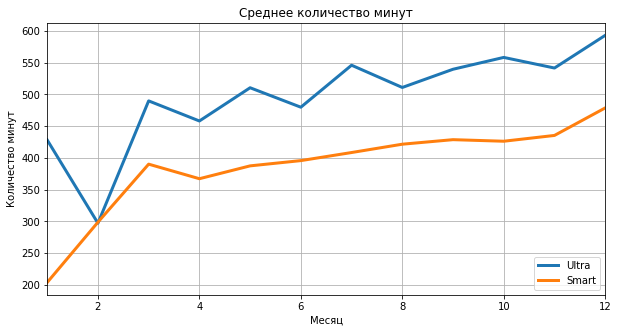

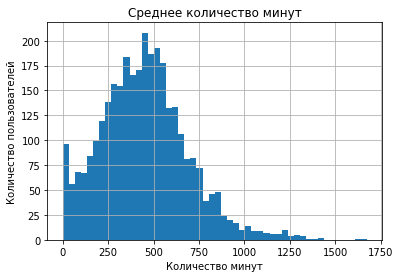

In [20]:
total_minutes_pivot = data.pivot_table(index=['tariff_name'], values = 'total_minutes', aggfunc = ['mean', np.var, np.std])
print(total_minutes_pivot)

a = data[data.tariff_name == 'ultra'].groupby(['month'])["total_minutes"].mean()
b = data[data.tariff_name == 'smart'].groupby(['month'])["total_minutes"].mean()
a.plot(grid=True, label ='Ultra', linewidth = 3, figsize=(10, 5))
b.plot(grid=True, label = 'Smart', linewidth = 3, figsize=(10, 5), title='Среднее количество минут')
plt.xlabel('Месяц')
plt.ylabel('Количество минут')
plt.legend(loc='lower right')
plt.show()
data['total_minutes'].hist(bins=50)
plt.title('Среднее количество минут')
plt.xlabel('Количество минут')
plt.ylabel('Количество пользователей')
plt.show()

Клиент телеком оператора в среднем тратит порядка 450 минут в месяц, для пользователей тарифа ultra характерно большее количество совершенных звонков (пориблезительно 526 минут в месяц), чем для тарифа smart (418 минут в месяц). Стоит так же отметить, что количество использованных минут растет у тарифа smart плавно (от 200 минут в месяц до 470 минут в месяц в течение года), тогда как у тарифа ultra характерно не равномерное увеличение числа потраченных минут - если май показывает рост числа использованных минут, то следующий месяц - июнь, показывает спад и так на протяжении всего года. Но стоит отметить так же положительный рост общего числа использования (с 430 минут в месяц до 590 минут в месяц). Анализируя распределение общего числа пользователей по количеству использованных минут, то можно сказать, что оно близкое к нормальному с небольшой скошенностью вправо. Имеется определенное число пользователей, которые не пользуются звонками вообще. О плавности роста также сообщает стандартное отклонение: у тарифа смарт оно равно 190 минутам, тогда как у тарифа ultra - 317 минутам. Отклонение от среднего значения  больше у тарифа ultra, что говорит о том, что каждый месяц меняется количество уникальных клиентов, которые, возможно, разочаровались в тарифе и перешли на более удобный.

                         mean               var               std
            total_internet_gb total_internet_gb total_internet_gb
tariff_name                                                      
smart               16.328847         33.028705          5.747061
ultra               19.494416         97.091686          9.853511


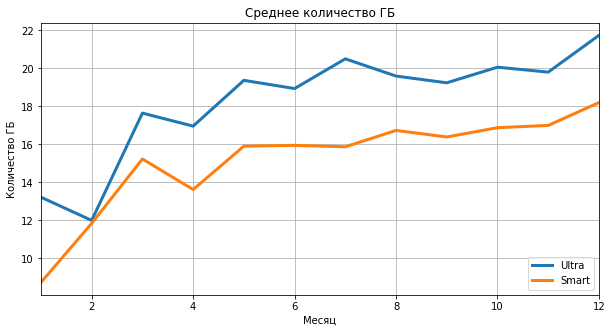

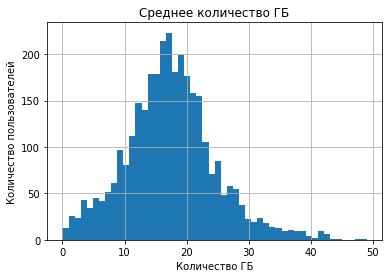

In [14]:
total_internet_gb_pivot = data.pivot_table(index=['tariff_name'], values = 'total_internet_gb', aggfunc = ['mean', np.var, np.std])
print(total_internet_gb_pivot)

a = data[data.tariff_name == 'ultra'].groupby(['month'])["total_internet_gb"].mean()
b = data[data.tariff_name == 'smart'].groupby(['month'])["total_internet_gb"].mean()
a.plot(grid=True, label ='Ultra', linewidth = 3, figsize=(10, 5))
b.plot(grid=True, label ='Smart', linewidth = 3, figsize=(10, 5), title='Среднее количество ГБ')
plt.xlabel('Месяц')
plt.ylabel('Количество ГБ')
plt.legend(loc='lower right')

plt.show()
data['total_internet_gb'].hist(bins=50)
plt.title('Среднее количество ГБ')
plt.xlabel('Количество ГБ')
plt.ylabel('Количество пользователей')
plt.show()

В среднем клиент тратит порядка 17 гб интернет трафика ежемесячно, для пользователей тарифа ultra характерно большее количество использованных гигабайт интернет трафика (приблизительно 19,5 гб в месяц), в отличие от тарифа smart (16,3 гб в месяц). Стоит так же отметить, что количество использованных гб растет у тарифа smart более плавно (от 5 гб в месяц до 18 гб в месяц в течение года), тогда как у тарифа ultra характерно не равномерное увеличение числа потраченных гб - рост и небольшой спад чередуются месяц за месяцем. Но стоит отметить так же положительный рост общего числа использования (с 13 гб в месяц до 21 гб в месяц). Распределение общего числа пользователей по количеству использованных гигабайт интернет трафика нормальное. Стандартное отклонение от среднего тарифа ultra больше, чем у альтернативного тарифа. Связываем так же с разным количеством клиентов, пользующихся оператором.

                      mean            var            std
            total_messages total_messages total_messages
tariff_name                                             
smart            33.384029     796.812958      28.227876
ultra            49.363452    2285.266143      47.804457


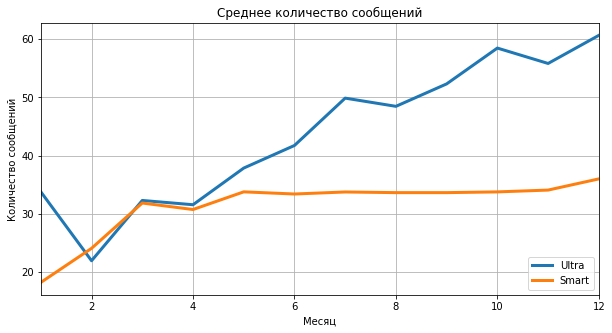

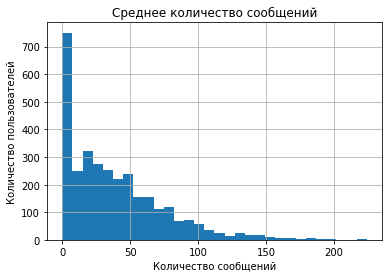

In [22]:
total_messages_pivot = data.pivot_table(index=['tariff_name'], values = 'total_messages', aggfunc = ['mean', np.var, np.std])
print(total_messages_pivot)
#total_messages_pivot.reset_index(inplace=True)
#total_messages_pivot.rename(columns={'total_messages': ''}, inplace=True)
#print(total_messages_pivot.columns())
#total_messages_pivot['mean'].plot(grid=True, label ='Ultra', linewidth = 3, figsize=(10, 5))

a = data[data.tariff_name == 'ultra'].groupby(['month'])["total_messages"].mean()
b = data[data.tariff_name == 'smart'].groupby(['month'])["total_messages"].mean()
a.plot(grid=True, label ='Ultra', linewidth = 3, figsize=(10, 5))
b.plot(grid=True, label ='Smart', linewidth = 3, figsize=(10, 5), title='Среднее количество сообщений')
plt.xlabel('Месяц')
plt.ylabel('Количество сообщений')
plt.legend(loc='lower right')
plt.show()

data['total_messages'].hist(bins=30)
plt.title('Среднее количество сообщений')
plt.xlabel('Количество сообщений')
plt.ylabel('Количество пользователей')
plt.show()

В среднем клиент отправляет порядка 37 сообщений ежемесячно, для пользователей тарифа ultra характерно большее количество отправленных сообщений (приблизительно 49 сообщений в месяц), в отличие от тарифа smart (33 в месяц). Стоит так же отметить, что количество отправленных смс растет у тарифа smart (от 17 до 35) и ultra (от 35 до 60) каждый месяц в течение года. Для количества отправленных сообщений характерно распределение Пуассона, то есть не равномерно распределены относитьльно среднего значения. Велико значение так же тех клиентов, которые вообще не используют смс для связи в ежемесячном рассмотрении.

В целом стоит отметить, что с каждым месяцем показатели использвания трафика (смс, звонки, интернет) постепенно увеличиваются, что говорит о том, что при неизменной стоимости услуг для обоих тарифов "Мегалайн" получает больше прибыли. Стандартное отклонение обоих тарифов говорит о том, что тариф smart развивается плавнее и равномернее. Тогда как тариф ultra имеет более непредсказуемую динамику роста.

### 5. Проверка гипотез

Для того чтобы понять различаются ли средняя выручка пользователей тарифов «Ультра» и «Смарт» сформулируем гипотизу по критерию сравнения средних двух генеральных совокупностей так как мы имеем две совокупности. у которых нужно сравнить среднее значение (в нашем случае - выручку).

Нулевая гипотеза будет звучать так: средняя выручка двух тарифов ("Смарт" и "Ультра") равна между собой. Тогда альтернативная будет звучать следующим образом: средняя выручка двух тарифов ("Смарт" и "Ультра") не равна между собой.

In [56]:
sample_1 = data[data.tariff_name == 'ultra'].groupby(['user_id'])["m_revenue"].mean()
sample_2 = data[data.tariff_name == 'smart'].groupby(['user_id'])["m_revenue"].mean()

#print(sample_1.mean())
#print(sample_2.mean())

alpha = .05

results = st.ttest_ind(
    sample_1, 
    sample_2)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Средняя выручка двух тарифов (Смарт и Ультра) не равна между собой")
else:
    print("Средняя выручка двух тарифов (Смарт и Ультра) равна между собой")

p-значение: 2.983728825353049e-40
Средняя выручка двух тарифов (Смарт и Ультра) не равна между собой


Мы отвергаем нулевую гипотезу "средняя выручка двух тарифов ("Смарт" и "Ультра") равна между собой.", соответственно делаем вывод, что средняя выручка различна, что подтверждает наши выводы, сделанные в третьем пункте.

Для того чтобы понять различаются ли средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов сформулируем гипотизу по критерию сравнения средних двух генеральных совокупностей так как мы имеем две совокупности. у которых нужно сравнить среднее значение (в нашем случае - выручку).

Нулевая гипотеза будет звучать так: средняя выручка пользователей из Москвы равна выручке пользователей из других регионов. Тогда альтернативная будет звучать следующим образом: средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

In [ ]:
sample_1 = data[data.city == 'Москва'].groupby(['user_id'])["m_revenue"].mean()
sample_2 = data[data.city != 'Москва'].groupby(['user_id'])["m_revenue"].mean()

alpha = .05

#print(sample_1.mean())
#print(sample_2.mean())

results = st.ttest_ind(
    sample_1, 
    sample_2)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов")
else:
    print("средняя выручка пользователей из Москвы равна выручке пользователей из других регионов")

Мы не отвергаем нулевую гипотезу "Средняя выручка пользователей из Москвы равна выручке пользователей из других регионов.".

### 6. Общий вывод

В данном прокте были исследованы поведение пятисот пользователей оператора связи "Мегалайн" за 2018 год. В ходе исследования приведены данные к необходимым типам, удалены пропущенные значения, исправлены общие ошибки в данных. Для каждого пользователя рассчитаны количество сделанных звонков и израсходованных минут разговора по месяцам, количество отправленных сообщений по месяцам, объем израсходованного интернет-трафика по месяцам. 

Рассчитали так же помесячную выручку с каждого пользователя и выяснили, что большую выручку в абсолютном выражении приносит тариф смарт - 2,88 млн рублей. Удалось выяснить, что 1 пользователь тарифа смарт приносит компании 1290 рублей выручки в месяц, тогда как пользователь тарифа ультра - 2070 рублей в месяц. Ежемесячный платеж для тарифа ультра равен 1950 рублей, что примерно сопоставимо с выручкой от одного пользователя по данному тарифу. Тогда как у тарифа смарт ежемесячная абонентская плата составляет 550 рублей, но один пользователь в среднем приносит более чем в два раза больше (1290 рублей) в месяц. 

Проанализировав сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц можно констатировать рост пользования по обоим тарифам в течение года. Стоит так же отметить, что более плавнопротекающий рост наблюдается у тарифа смарт, ему не характерны, в отличие от тарифа ультра, характерные спады активности пользователей. 

В ходе исследования удалось выявить, что средняя выручка двух тарифов (Смарт и Ультра) не равна между собой и средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов путем постановки гипотезы и проверки на критерии сравнения средних двух генеральных совокупностей.